In [1]:
global file
file = input('Selet a folder to save output') ##enter your file path here - the file is in the repo "summary_stats.csv".
raw_file = file

In [2]:
from datetime import datetime
from datetime import date
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import math
import pandas as pd
import  os as os
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
sg = Subgrounds()
snapshot = sg.load_api('https://hub.snapshot.org/graphql')

In [107]:
snapshot.Proposal.datetime = SyntheticField(
  lambda timestamp: str(datetime.fromtimestamp(timestamp)),
  SyntheticField.STRING,
  snapshot.Proposal.end,
)

In [108]:
spacename = input('spacename plz?')
# based on their url, for example "curve.eth" for  https://snapshot.org/#/curve.eth
proposals = snapshot.Query.proposals(
  orderBy='created',
  orderDirection='desc',
  first=10000,
  where=[
    snapshot.Proposal.space == spacename, ##'fuse.eth',
    snapshot.Proposal.state == 'closed'
    ##snapshot.Proposal.title == 'OIP-18: Reward rate framework and reduction',
  ]
)

In [109]:
proposals_snapshots = sg.query_df([
    proposals.title,
    proposals.id,
    proposals.body,
    proposals.scores_total
])

In [110]:
proposals_choices = sg.query(proposals.choices)

In [111]:
proposals_choices = pd.DataFrame(proposals_choices)

In [112]:
olympus_governance_view = pd.concat([proposals_snapshots,proposals_choices], axis=1)

In [113]:
##let's view the output just to make sure
olympus_governance_view.head(5)

,proposals_title,proposals_id,proposals_body,proposals_scores_total,0,1,2,3,4,5,6
0,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,**Summary:**\n\nGrant Policy Authority to:\nCo...,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
1,OIP-104: Deploy Permissionless OP as Bond Prot...,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,#### Summary\nDeploy the new system of Permiss...,296088.544685,For: Deploy Bond Protocol,Against: Do nothing,None,None,None,None,None
2,OIP-103 Balancer Migration,0xebd05bd5896c472eecceb380b345689fc5afcd295865...,**Summary**\n\nDesignate Balancer as the platf...,322598.605158,For: In support of proposal,Against: Not in support,None,None,None,None,None
3,OIP-101: Artemis Academy Grant Proposal,0xfb69ecfd9d0f366635951c7b337cf44753ecb8c24b75...,## Executive Summary from Grants Working Group...,174038.840633,Approve $50k Grant to Artemis,Reject,None,None,None,None,None
4,OIP-102 Compensation Plan with Bonus Structure,0x5e3963823e0664c71172e94bb8fea703474537a367b0...,Summary:\nSeek Authority from the community to...,147539.503364,For,Against,None,None,None,None,None


In [114]:
#let's remove duplicate rows the easy way, and add the name of the DAO to the table
olympus_governance_view_clean = olympus_governance_view.copy(deep=True)
olympus_governance_view_clean.insert(0, 'DAO', spacename)
olympus_governance_view_clean.head(10)

,DAO,proposals_title,proposals_id,proposals_body,proposals_scores_total,0,1,2,3,4,5,6
0,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,**Summary:**\n\nGrant Policy Authority to:\nCo...,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
1,olympusdao.eth,OIP-104: Deploy Permissionless OP as Bond Prot...,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,#### Summary\nDeploy the new system of Permiss...,296088.544685,For: Deploy Bond Protocol,Against: Do nothing,None,None,None,None,None
2,olympusdao.eth,OIP-103 Balancer Migration,0xebd05bd5896c472eecceb380b345689fc5afcd295865...,**Summary**\n\nDesignate Balancer as the platf...,322598.605158,For: In support of proposal,Against: Not in support,None,None,None,None,None
3,olympusdao.eth,OIP-101: Artemis Academy Grant Proposal,0xfb69ecfd9d0f366635951c7b337cf44753ecb8c24b75...,## Executive Summary from Grants Working Group...,174038.840633,Approve $50k Grant to Artemis,Reject,None,None,None,None,None
4,olympusdao.eth,OIP-102 Compensation Plan with Bonus Structure,0x5e3963823e0664c71172e94bb8fea703474537a367b0...,Summary:\nSeek Authority from the community to...,147539.503364,For,Against,None,None,None,None,None
5,olympusdao.eth,OIP-100: Adjust Reward Rate,0x41607de83deda264c5f3ed567b148a71c2cd786124e2...,"Summary\nAdjust reward rate to 0.1186%, the mi...",459680.967536,Reject: do nothing,Approve: adjust to 0.1186%,None,None,None,None,None
6,olympusdao.eth,OIP-73A: Treasury Framework Amendment,0xffdcf93b7a0c09c606bd72fd56b17ea63952627aa19e...,This amendment is to provide clarity on what i...,229834.722976,Approve Amendment,Reject Amendment,None,None,None,None,None
7,olympusdao.eth,Legal Expenses and Indemnification,0xea9f1a66ee291dc32ff7b5855f51112eaefb01a34e12...,### Summary\n\nAuthorize Olympus DAO to indemn...,74495.344242,For,Against,None,None,None,None,None
8,olympusdao.eth,OIP-99 - Provide Liquidity on FDT-ETH Pair,0xf572fc6871e2860fdf0ad913d4ade2bb44cfa7566713...,**Summary:**\nSupport Fiat DAO by providing li...,96922.105238,Approve: provide liqudity,Reject,None,None,None,None,None
9,olympusdao.eth,OIP-97 - Cross-Chain EconOHMy Expansion Budget,0x2da5f3378fa9bb3622280648c8e03c31ca7a53681c8c...,RFC can be found https://forum.olympusdao.fina...,286784.051470,Approve new Cross-Chain Budget,Reject new Cross-Chain Budget,None,None,None,None,None


In [93]:
path =file+'/'+spacename+'_proposals_table_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'_proposals.csv'
olympus_governance_view_clean.to_csv(path, index = False)

In [115]:
total_proposals = len(olympus_governance_view_clean)
total_proposals

209

In [116]:
proposal_id = olympus_governance_view_clean.iloc[0,2]
proposal_id

'0xe6233a0b159f58a97ba41019bd09cb904bd0120f656dcaac3c7aa33d862abf72'

In [117]:
vote_tracker = snapshot.Query.votes(
orderBy = 'created',
orderDirection='desc',
first=10000,
where=[
  snapshot.Vote.proposal == proposal_id
]
)

In [118]:
voting_snapshots_list = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
])

In [119]:
voting_snapshots_list.head(10)

,votes_id,votes_voter,votes_created,votes_choice,votes_vp
0,bafkreih44a44m4ej2loni54bjgzz2nmbfc2lit324hiqh...,0xCc0002972d604DceD87f079306ad6a555C9Fe122,1658759354,2,376.437434
1,0x473f04dd52469588cc54a10017482b98ce083ff1eb0d...,0xd8929472A97db29867fE5C6F18922c24F59A7A71,1658757220,2,1057.429981
2,0xbe37fd97164f24b6ee13f4b633ad3ff9413493c5069c...,0xBDbFdf3e82fC9d2bE1352e252aB1Ce2287fC2122,1658755919,2,87.229162
3,0x121f54a30024ec4166d1ac4449a3d8293bf4a85d6753...,0x903A97385f13597ea34e1952C6B50D303498FceB,1658753952,2,435.343234
4,0xbbafaefe287c9ce99473382b0b11356d8e8dbb4f9de7...,0x627D5Ed9d7b2EC21a785aB4C560492B3eB65fB3f,1658753659,2,84.418999
5,0xbb2feae49eb83f700128e5f9af2184f2bfd4e03d9edd...,0x5cd8165A19fBD93D3A360c4b3DE1e3C46f7dBF33,1658749956,2,26.872701
6,bafkreifvprmnw7hzs7xr63o6a4t3si755imo42vuojmu4...,0x2A92195A610f21f8DA1801Ff9756Aaa11319Ef68,1658748768,2,8.241513
7,0x188566d3e60a2f2c2860f3917b97fccaec3ee86cfe1a...,0xEb4Db23c27253077Fb3080adda6C5C127b0dACAe,1658734822,2,1791.640652
8,0xcd60d59fcb69e159c264bbb71cb16c238a90980a3f6e...,0x71Cc743110f40e02f9412b466b82cEc003aF0b0A,1658734411,2,2222.961050
9,0xd539efddec0c574ac889ec932ad92d8ac14d1d265636...,0x277de71B4F1aeeEc027b75ccC0761b7D9d5a54C1,1658734363,2,14461.642338


In [121]:
x=0
while x <total_proposals:
    proposal_id = olympus_governance_view_clean.iloc[x,2]

    vote_tracker = snapshot.Query.votes(
    orderBy = 'created',
    orderDirection='desc',
    first=10000,
    where=[
      snapshot.Vote.proposal == proposal_id
    ]
    )
    voting_snapshots = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
    ])

    voting_snapshots['Proposal'] = proposal_id
    voting_snapshots_list=pd.concat([voting_snapshots_list, voting_snapshots])

    x=x+1
    progress = 100*(round(x/total_proposals,0))
    ##clear_output(wait=True)

print(len(voting_snapshots_list),' records')

57898  records


In [100]:
#spit out the file
path =file+'/'+spacename+'_voting_snapshots_list_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'.csv'
voting_snapshots_list.to_csv(path, index = False)

In [122]:
#I join these two tables to create my charts as it makes life easier. We are going to build the charts here now, so here we go
governance_data = pd.merge(voting_snapshots_list, olympus_governance_view_clean, how='inner', left_on='Proposal', right_on='proposals_id')
del governance_data["proposals_body"]
governance_data.head(10)

,votes_id,votes_voter,votes_created,votes_choice,votes_vp,Proposal,DAO,proposals_title,proposals_id,proposals_scores_total,0,1,2,3,4,5,6
0,bafkreih44a44m4ej2loni54bjgzz2nmbfc2lit324hiqh...,0xCc0002972d604DceD87f079306ad6a555C9Fe122,1.658759e+09,2,376.437434,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
1,0x473f04dd52469588cc54a10017482b98ce083ff1eb0d...,0xd8929472A97db29867fE5C6F18922c24F59A7A71,1.658757e+09,2,1057.429981,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
2,0xbe37fd97164f24b6ee13f4b633ad3ff9413493c5069c...,0xBDbFdf3e82fC9d2bE1352e252aB1Ce2287fC2122,1.658756e+09,2,87.229162,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
3,0x121f54a30024ec4166d1ac4449a3d8293bf4a85d6753...,0x903A97385f13597ea34e1952C6B50D303498FceB,1.658754e+09,2,435.343234,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
4,0xbbafaefe287c9ce99473382b0b11356d8e8dbb4f9de7...,0x627D5Ed9d7b2EC21a785aB4C560492B3eB65fB3f,1.658754e+09,2,84.418999,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
5,0xbb2feae49eb83f700128e5f9af2184f2bfd4e03d9edd...,0x5cd8165A19fBD93D3A360c4b3DE1e3C46f7dBF33,1.658750e+09,2,26.872701,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
6,bafkreifvprmnw7hzs7xr63o6a4t3si755imo42vuojmu4...,0x2A92195A610f21f8DA1801Ff9756Aaa11319Ef68,1.658749e+09,2,8.241513,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
7,0x188566d3e60a2f2c2860f3917b97fccaec3ee86cfe1a...,0xEb4Db23c27253077Fb3080adda6C5C127b0dACAe,1.658735e+09,2,1791.640652,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
8,0xcd60d59fcb69e159c264bbb71cb16c238a90980a3f6e...,0x71Cc743110f40e02f9412b466b82cEc003aF0b0A,1.658734e+09,2,2222.961050,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None
9,0xd539efddec0c574ac889ec932ad92d8ac14d1d265636...,0x277de71B4F1aeeEc027b75ccC0761b7D9d5a54C1,1.658734e+09,2,14461.642338,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,359890.743297,Reject Amendment,Approve Amendment,None,None,None,None,None


In [70]:
#Spit out the file, but save it in its own folder for easy access
final_file = file+'\\'+'final'
final_raw_file = final_file
os.makedirs(final_raw_file, exist_ok=True)
final_path =file+'\\'+spacename+'governance_data_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(governance_data))+'.csv'
governance_data.to_csv(final_path, index = False)

In [123]:
crunch_data = db.query("select "
                           "Proposal"
                           ",votes_voter "
                           ",votes_choice"
                           ",votes_vp"
                           ",votes_created"
                           ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp"
                           ",sum(votes_vp) over (Partition by Proposal) as total_vp"
                           ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentage_of_total_vp "
                           ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp "
                       ",round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp_stepped "
                           ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                           ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) total_voters "
                           ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                           ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                       "from "
                       "    governance_data  "
                       ""
                       "Group by "
                       "    Proposal"
                       "    ,votes_voter"
                       "    ,votes_choice"
                       "    , votes_vp "
                       "    , votes_created "
                       ""
                       "Order by "
                       "    Proposal, "
                       "    votes_vp desc "
                       "    , votes_created asc"
                       "").df()


crunch_data.insert(0, 'DAO', spacename)
crunch_data.head(n=10)


,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,cumulative_vp,total_vp,percentage_of_total_vp,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped
0,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0x318A11FB434333DE60B3585428CC888eA1E22C67,1,8057.904205,1.646646e+09,8057.904205,32409.067455,0.248631,0.248631,0.0,1,1,0.011628,1.0
1,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xED2A18a533c452293934F5c7A55EbAa5c2B6E6D8,1,5399.999679,1.646647e+09,13457.903883,32409.067455,0.166620,0.415251,0.0,2,2,0.023256,2.0
2,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xEA4B752083c7A386ff7556BB7C0b01876b4eE96F,1,3312.725382,1.646443e+09,16770.629265,32409.067455,0.102216,0.517467,1.0,3,3,0.034884,3.0
3,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0x8dF24569a74E094bf75E17d1F0c238D39B5E17B5,1,1462.390149,1.646619e+09,18233.019414,32409.067455,0.045123,0.562590,1.0,4,4,0.046512,5.0
4,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xA58C5c1D9589d859AB5481bEa3b39A93079A1a57,1,1321.882651,1.646468e+09,19554.902064,32409.067455,0.040787,0.603377,1.0,5,5,0.058140,6.0
5,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xA523A334C8e0E43f09928890064cd75469b3faE7,1,1289.864265,1.646505e+09,20844.766329,32409.067455,0.039799,0.643177,1.0,6,6,0.069767,7.0
6,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xB37E5BC97476E2E980Ff6e22f2AcF0070d38f042,1,1068.692959,1.646549e+09,21913.459287,32409.067455,0.032975,0.676152,1.0,7,7,0.081395,8.0
7,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xcCe02875B22284877ebf08C9e6FdEe319B01702c,1,927.022268,1.646419e+09,22840.481555,32409.067455,0.028604,0.704756,1.0,8,8,0.093023,9.0
8,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0x7672B17D5Eebb7194d57066f86FBcb4e85a7e10E,1,810.035653,1.646704e+09,23650.517208,32409.067455,0.024994,0.729750,1.0,9,9,0.104651,10.0
9,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0x8353A1264A7D8c7DE77a8cd50A58F649A352D7aB,1,759.613668,1.646659e+09,24410.130876,32409.067455,0.023438,0.753188,1.0,10,10,0.116279,12.0


In [130]:
#leaders = crunch_data.loc[crunch_data['proposal_voter_rank'] <=3]
#leader_count = leaders.votes_voter.nunique()
#leader_count
#DONT ASK ME WHY THIS DIDNT WORK. HAVE TO DO IT THE UGLY WAY

leader_ranks = db.query("with leader_ranks as "
                        "(Select distinct "
                        "   B.Proposal"
                        "   ,B.votes_voter"
                        "   ,B.proposal_voter_rank "
                        "   ,(B.proposal_voter_rank +1) as leader_rank "
                        "From "
                        "   (select "
                               "Proposal"
                               ",votes_voter "
                               ",votes_choice"
                               ",votes_vp"
                               ",votes_created"
                               ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp"
                               ",sum(votes_vp) over (Partition by Proposal) as total_vp"
                               ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentage_of_total_vp "
                               ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp "
                           "    ,round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp_stepped "
                               ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                               ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) total_voters "
                               ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                               ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                           "from "
                           "    governance_data  "
                               ""
                           "Group by "
                           "    Proposal"
                           "    ,votes_voter"
                           "    ,votes_choice"
                           "    , votes_vp "
                           "    , votes_created "
                           ""
                           "Order by "
                           "    Proposal, "
                           "    votes_vp desc "
                           "    , votes_created asc) B "
                        "where "
                        "   B.cum_percentage_of_total_vp<=0.5) "
                        ""
                        "Select "
                        "   *"
                        "From crunch_data A"
                        "   Join leader_ranks B on A.proposal_voter_rank = B.leader_rank and A.Proposal = B.Proposal"
                        ""
                    ).df()
leader_ranks



,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,cumulative_vp,total_vp,percentage_of_total_vp,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped,Proposal_2,votes_voter_2,proposal_voter_rank_2,leader_rank
0,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xED2A18a533c452293934F5c7A55EbAa5c2B6E6D8,1,5399.999679,1.646647e+09,13457.903883,32409.067455,0.166620,0.415251,0.0,2,2,0.023256,2.0,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0x318A11FB434333DE60B3585428CC888eA1E22C67,1,2
1,olympusdao.eth,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xEA4B752083c7A386ff7556BB7C0b01876b4eE96F,1,3312.725382,1.646443e+09,16770.629265,32409.067455,0.102216,0.517467,1.0,3,3,0.034884,3.0,0x00fd601fd700678a9d6b7e484e742ccbbcf2f7f27c6d...,0xED2A18a533c452293934F5c7A55EbAa5c2B6E6D8,2,3
2,olympusdao.eth,0x015cb9276a34ae7ec7c00e4c780fcbd35d96f56e27e8...,0xf5B4635f3858a2Bc80a17BD4450E05a35Ad99A72,1,7306.154702,1.638653e+09,30187.167937,91791.558579,0.079595,0.328866,0.0,3,3,0.005059,1.0,0x015cb9276a34ae7ec7c00e4c780fcbd35d96f56e27e8...,0xf280f037CDBDa99727ddF5DfEde91e68FA78605c,2,3
3,olympusdao.eth,0x015cb9276a34ae7ec7c00e4c780fcbd35d96f56e27e8...,0xa59f5FF4e3dDFc599F5ebEdc824Ba52143925d1B,1,4851.343473,1.638667e+09,35038.511410,91791.558579,0.052852,0.381718,0.0,4,4,0.006745,1.0,0x015cb9276a34ae7ec7c00e4c780fcbd35d96f56e27e8...,0xf5B4635f3858a2Bc80a17BD4450E05a35Ad99A72,3,4
4,olympusdao.eth,0x015cb9276a34ae7ec7c00e4c780fcbd35d96f56e27e8...,0x86F032cD94D4A681bf4B8328b0D958Fd2EA77A4D,1,2057.788544,1.638722e+09,37096.299954,91791.558579,0.022418,0.404136,0.0,5,5,0.008432,1.0,0x015cb9276a34ae7ec7c00e4c780fcbd35d96f56e27e8...,0xa59f5FF4e3dDFc599F5ebEdc824Ba52143925d1B,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,olympusdao.eth,0x9dd714745b82cb7e93520368a7c3da5349e16017133b...,0x8D51A9Ddd59064F719D98b6a9B2f073811227c5e,1,86.702543,1.637722e+09,188.356630,544.735010,0.159165,0.345777,0.0,2,2,0.083333,8.0,0x9dd714745b82cb7e93520368a7c3da5349e16017133b...,0x2A129B795c382B5ce555F030f70e843FeD4a8617,1,2
1121,olympusdao.eth,0xf572fc6871e2860fdf0ad913d4ade2bb44cfa7566713...,0x6716b6737620922ACC8F8B8A4c2A6D706F3224FF,1,7740.576062,1.654928e+09,45438.557814,96922.105238,0.079864,0.468815,0.0,3,3,0.025641,3.0,0xf572fc6871e2860fdf0ad913d4ade2bb44cfa7566713...,0x75488002344542722E772a861A60522c51457460,2,3
1122,olympusdao.eth,0x88b17056b2677673df2731eec8431a3aadcdc7f8f348...,0xd8cbfb514D0A3d09b8423477e5627bc78589aBD4,1,7069.855994,1.643333e+09,39649.160710,86124.484485,0.082089,0.460370,0.0,5,5,0.021459,2.0,0x88b17056b2677673df2731eec8431a3aadcdc7f8f348...,0x4d892c3A98a1c096D9b52872D242c9668bA52D44,4,5
1123,olympusdao.eth,0xb2de94422fd9153669ccbcdca648238d25d28f79721e...,0x86105840C67cFa2f2D50F80946f22a3d49430dCA,2,1827.756183,1.638246e+09,4246.124626,9870.635713,0.185171,0.430177,0.0,2,2,0.021978,2.0,0xb2de94422fd9153669ccbcdca648238d25d28f79721e...,0xB825c207600aDfD3fB23fEcE0b90AEFD4A017Fa8,1,2


In [131]:
dao_members = crunch_data.groupby('DAO').votes_voter.nunique()
dao_members = dao_members.iloc[0]
leader_count =leader_ranks.votes_voter.nunique()
elite = round((leader_count)/(dao_members),4)

print(dao_members, "{0:.2%}".format(elite))


8891 3.61%


In [132]:
##spit out the file!
crunch_data_path =final_file+'\\'+spacename+'_crunch_data_path'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'
crunch_data.to_csv(crunch_data_path, index = False)

C:\Users\ianfe\AppData\Local\Temp\ipykernel_14436\2233744753.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp","percentage_voters_counted"].agg("mean").reset_index()


AxesSubplot(0.125,0.125;0.775x0.755)


,percentage_voters_counted_stepped,cum_percentage_of_total_vp,percentage_voters_counted
0,0.0,0.202418,0.003378
1,1.0,0.337749,0.010068
2,2.0,0.473351,0.019941
3,3.0,0.554047,0.029971
4,4.0,0.613534,0.040008
...,...,...,...
96,96.0,0.999960,0.959949
97,97.0,0.999983,0.969953
98,98.0,0.999995,0.979982
99,99.0,0.999999,0.989888


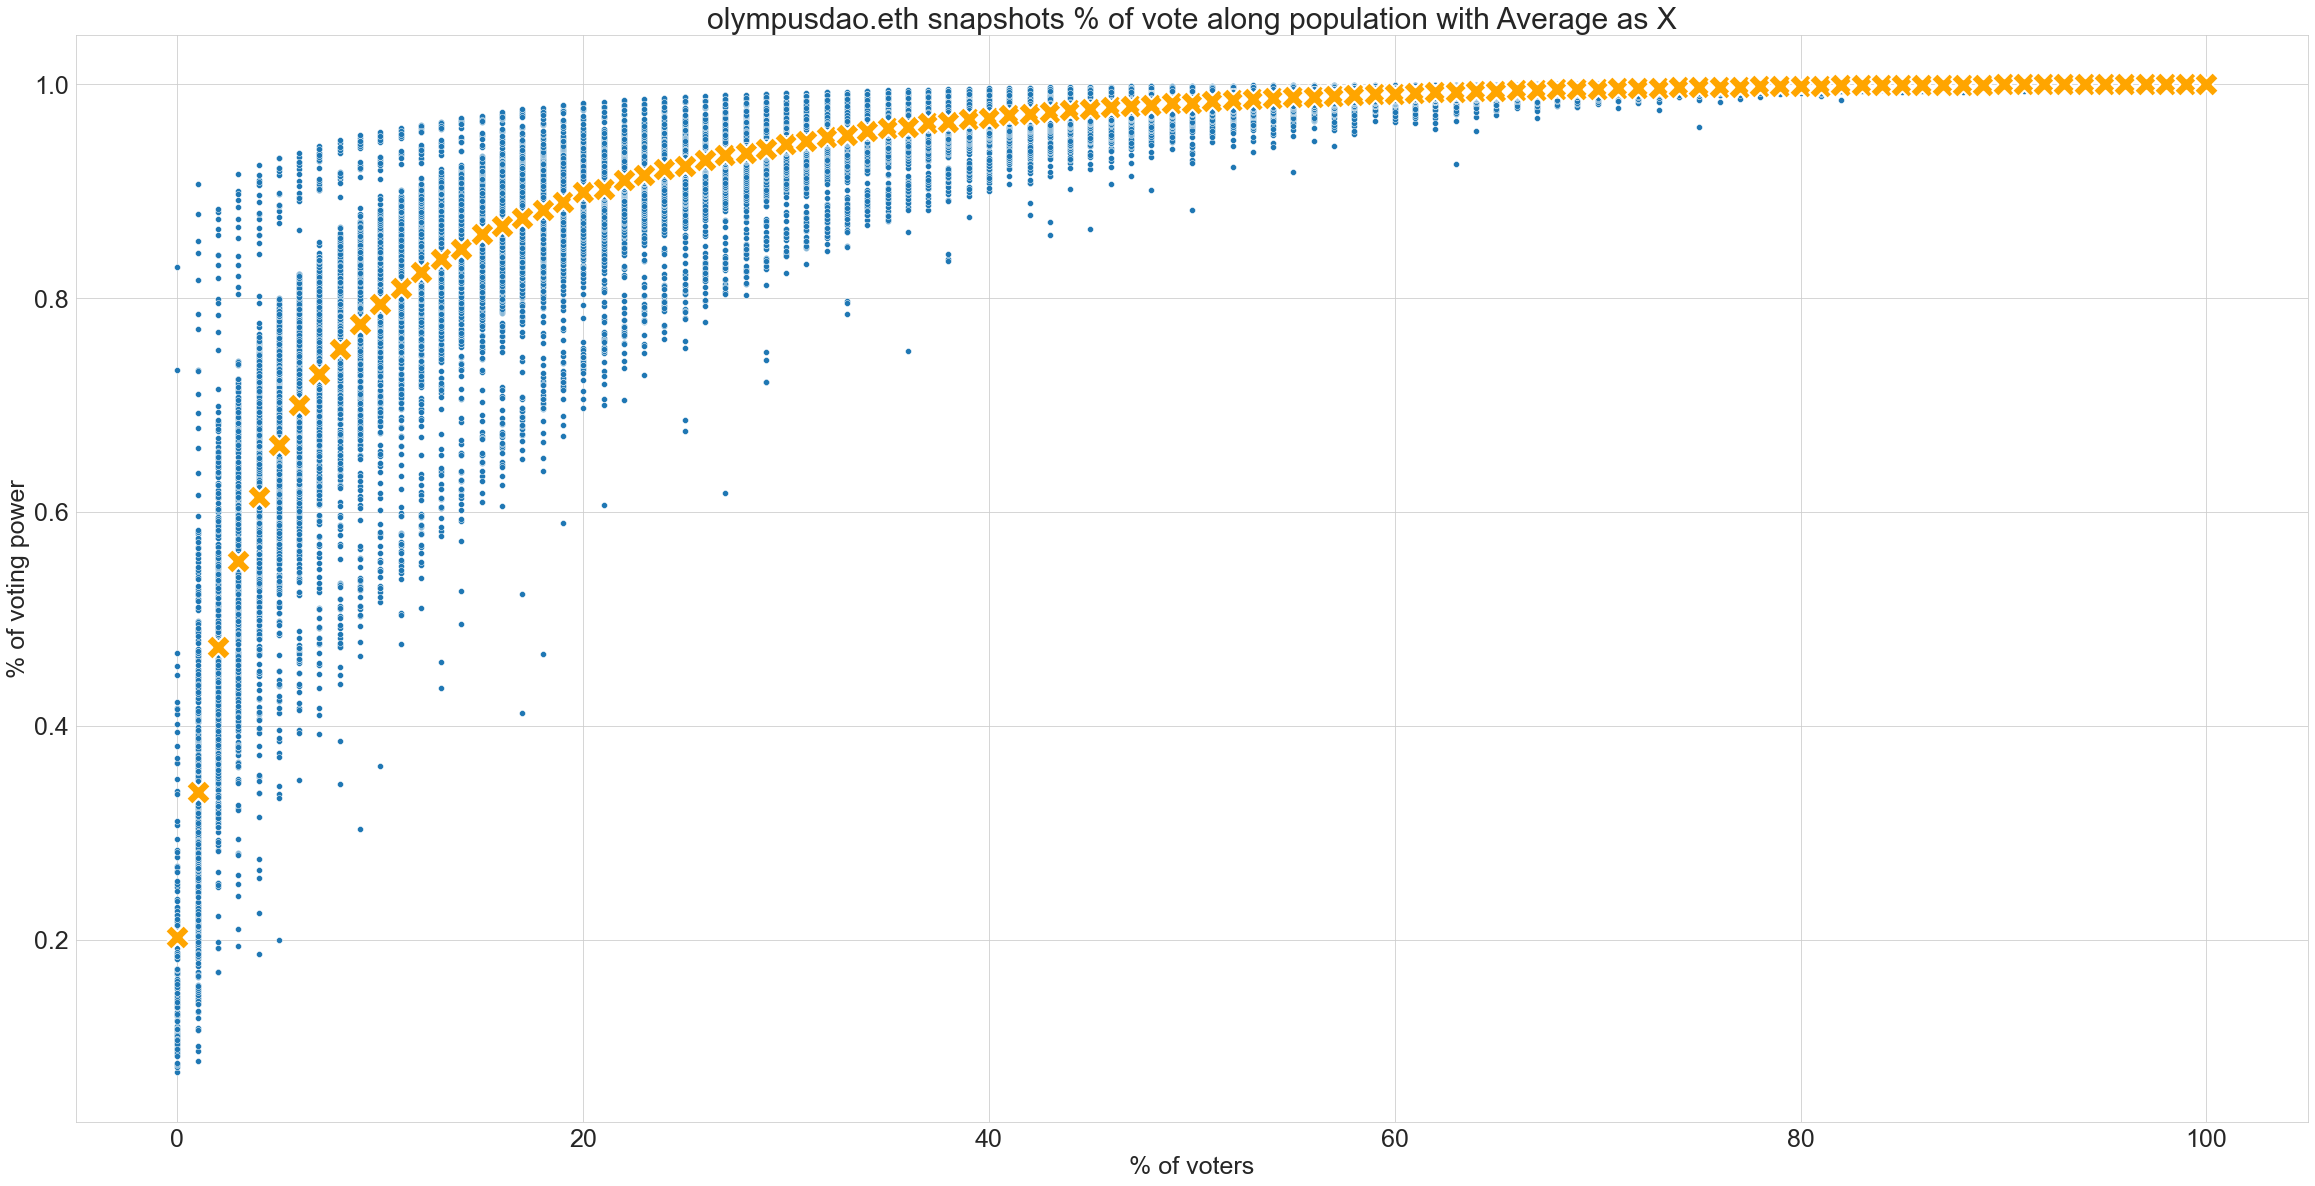

In [133]:
plt.rc("figure", figsize=(40, 20))
sns.set_style("whitegrid")
plt.rc("font", size=25)
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp","percentage_voters_counted"].agg("mean").reset_index()
##print(data_means)
plot_title = spacename + ' snapshots % of vote along population with Average as X'

ax=sns.scatterplot(data=crunch_data, y="cum_percentage_of_total_vp",x="percentage_voters_counted_stepped").set(title=plot_title,xlabel='% of voters',ylabel='% of voting power')
chart = sns.scatterplot(data=data_means,x="percentage_voters_counted_stepped",y="cum_percentage_of_total_vp",zorder=3, s=600,marker='X',color = 'orange')
#and save the chart file, too
plt.savefig(final_file+'\\'+spacename+' vote power distribution.png', dpi=100)

means_data_path =final_file+'\\'+spacename+'_means_'+'.csv'
data_means.to_csv(means_data_path, index = False)

print(chart)
data_means

The chart above shows what % of all possible votes has been cast (Y axis) as each incremental percent of the voting population casts their vote (X axis). Each line is a Proposal and has a unique color, so that a dot on each percent point represents what % of total voting power was accumulated by that group. The color represents which vote was cast.
The Orange X shows the average % of power accumulated across all elections.

In [134]:
p50 = db.query("select min(percentage_voters_counted) "
               "from data_means  where cum_percentage_of_total_vp>=0.5 ").df()
p50display = round(100*(p50.iloc[0,0]),2)
print('On average, a proposal at ', spacename, 'takes ',p50display,'% of the voting population.')

print('A total of ',leader_count, 'has driven the result of all proposals at',spacename,)
print('That\'s', ("{0:.2%}".format(elite)), 'of all DAO voters.')

On average, a proposal at  olympusdao.eth takes  3.0 % of the voting population.
A total of  321 has driven the result of all proposals at olympusdao.eth
That's 3.61% of all DAO voters.
